In [1]:
using JuMP, Ipopt, Plots, LaTeXStrings

In [2]:
include("params.jl");
S = S * 20

70000

Using a time step $\Delta=1\, hr$ and a forecast length of $T=24\,hr$, the cost is just a sum of the decision variables at each time step

In [3]:
S*αꜝ/Cᵢ

0.03901501501501502

In [30]:
model = Model(Ipopt.Optimizer);

# Optimization Variables
@variable(model, ϕ_h_gas[1:Nₜ] .>= 0)
@variable(model, ϕ_h_elect[1:Nₜ] .>= 0)
@variable(model, ϕ_c_elect[1:Nₜ] .>= 0)
@variable(model, Tᵢₘₐₓ .>= Tᵢ[1:Nₜ] .>= Tᵢₘᵢₙ)
@variable(model, Tw[1:Nₜ, 1:Nₓ])

# Initial Conditions
@constraint(model, Tw[1,:] == Twᵒ)
@constraint(model, Tᵢ[1] == Tᵢᵒ)

# Dynamic Constraints
forcingfunc(k) = 1/Cᵢ * (ϕ_h_gas[k]+ϕ_h_elect[k]-ϕ_c_elect[k]-S*αꜝ*(Tᵢ[k]-Tw[k,1]))
    # Implicit (Backward) Euler in time
@constraint(model, [k in 1:Nₜ-1], Tᵢ[k+1] == Tᵢ[k] + Δt * forcingfunc(k+1))
    # Centered Difference in space
@constraint(model, [k in 1:Nₜ-1, j in 2:Nₓ-1], Tw[k+1,j] == 
                Tw[k,j] + Δt*β/(Δx)^2 * (Tw[k+1,j+1]-2*Tw[k+1,j]+Tw[k+1,j-1]))
# Boundary Conditions (O(Δx²) forward and backward diff. first derivatives at the tips)
@constraint(model, [k in 2:Nₜ], 0 == αꜝ*(Tᵢ[k]-Tw[k,1]) + κ/(2*Δx)*(-3*Tw[k,1]+4*Tw[k,2]-Tw[k,3]))
@constraint(model, [k in 2:Nₜ], 0 == αꜝꜝ*(Tw[k,Nₓ]-Tₐ[k]) + κ/(2*Δx)*(3*Tw[k,Nₓ]-4*Tw[k,Nₓ-1]+Tw[k,Nₓ-2]))

# Cost Function
cost(ϕ_h_gas, ϕ_h_elect, ϕ_c_elect) = C_gas * sum(ϕ_h_gas) + 
C_elec_onPeak * sum(ϕ_h_elect[1:13] + ϕ_c_elect[1:13]) + 
C_elec_offPeak * sum(ϕ_h_elect[14:24] + ϕ_c_elect[14:24]);
@objective(model, Min, cost(ϕ_h_gas, ϕ_h_elect, ϕ_c_elect));
set_silent(model)
optimize!(model);
if !is_solved_and_feasible(model)
    error("Solver did not find an optimal solution")
end


In [29]:
~true

false

In [16]:
primal_status(model)

FEASIBLE_POINT::ResultStatusCode = 1

In [17]:
objective_value(model)

83.68396668420145

In [19]:
value.(Tw)

24×4 Matrix{Float64}:
 10.0     10.0     10.0     10.0
 17.1605  11.7765  10.8336  11.9745
 17.6386  13.9224  15.5711  29.0638
 18.3656  15.1861  15.1657  14.1317
 18.7166  16.6826  18.3898  28.1572
 19.2179  17.713   18.7843  20.8421
 19.5779  18.2345  18.1947  16.681
 19.728   18.8808  19.6495  24.055
 19.9889  18.9819  18.2276  13.9187
 20.0057  19.2857  19.3253  22.109
  ⋮                         
 20.8104  20.7659  19.7107  16.134
 20.6201  21.0401  22.1456  29.3383
 20.7218  21.2321  22.2226  23.4055
 20.7146  22.3172  26.6326  41.973
 21.089   23.3997  28.4168  37.8945
 21.5278  23.8227  27.1749  27.4224
 21.7142  24.0214  26.8255  28.756
 21.8614  23.6019  24.2935  18.6551
 21.7317  23.3616  24.3908  25.6634

In [6]:
Tᵢ_t, ϕ_h_gas_t, ϕ_h_elect_t, ϕ_c_elect_t, Tw_t = value.(Tᵢ), value.(ϕ_h_gas), value.(ϕ_h_elect), value.(ϕ_c_elect), value.(Tw);

In [7]:
function C2F(C::Float64)
    return C * 1.8 + 32
end
function F2C(F::Float64)
    return (F - 32) / 1.8
end

F2C (generic function with 1 method)

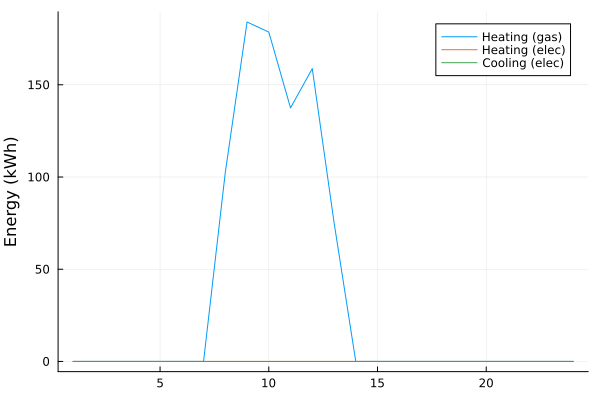

In [8]:
plot(ϕ_h_gas_t, label = "Heating (gas)")
plot!(ϕ_h_elect_t, label = "Heating (elec)")
plot!(ϕ_c_elect_t, label = "Cooling (elec)", legendfontsize=8, ylabel = "Energy (kWh)")

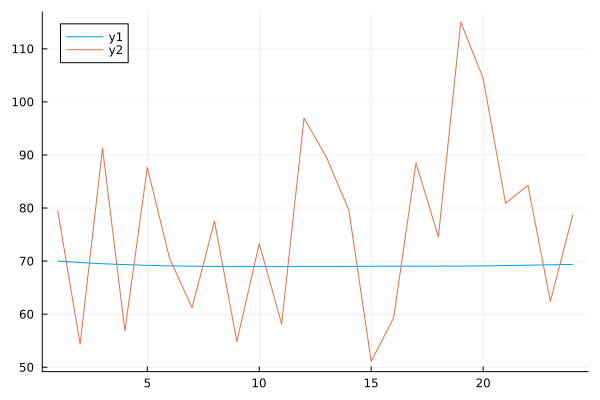

In [9]:
plot(C2F.(Tᵢ_t))
plot!(C2F.(Tₐ))

In [10]:
Tᵢ_t

24-element Vector{Float64}:
 21.11111111111111
 20.962764616026508
 20.83794277955021
 20.745105266486338
 20.668935064008206
 20.614450524341112
 20.575528521247275
 20.555555350404795
 20.555555350375467
 20.555555350342427
  ⋮
 20.579912786067695
 20.58142022304193
 20.586692056416364
 20.591495539686193
 20.610176176384503
 20.644631453608685
 20.684793487417473
 20.728975743059884
 20.766629325451056

In [11]:
Tw_t

24×4 Matrix{Float64}:
 10.0     10.0     10.0     10.0
 17.1605  11.7765  10.8336  11.9745
 17.6386  13.9224  15.5711  29.0638
 18.3656  15.1861  15.1657  14.1317
 18.7166  16.6826  18.3898  28.1572
 19.2179  17.713   18.7843  20.8421
 19.5779  18.2345  18.1947  16.681
 19.728   18.8808  19.6495  24.055
 19.9889  18.9819  18.2276  13.9187
 20.0057  19.2857  19.3253  22.109
  ⋮                         
 20.8104  20.7659  19.7107  16.134
 20.6201  21.0401  22.1456  29.3383
 20.7218  21.2321  22.2226  23.4055
 20.7146  22.3172  26.6326  41.973
 21.089   23.3997  28.4168  37.8945
 21.5278  23.8227  27.1749  27.4224
 21.7142  24.0214  26.8255  28.756
 21.8614  23.6019  24.2935  18.6551
 21.7317  23.3616  24.3908  25.6634

In [12]:
k = 1
 αꜝꜝ*(Tw_t[k,Nₓ]-Tₐ[k]) + κ/(2*Δx)*(3*Tw_t[k,Nₓ]-4*Tw_t[k,Nₓ-1]+Tw_t[k,Nₓ-2])


-0.19032428821498773

In [13]:
k=2
value(1/Cᵢ*S*αꜝ*(Tᵢ[k]-Tw[k,1]))

0.14834649517761966